# Identification of selective sweeps

## Setup

In [1]:
# Load require packages
library(tidyverse)
library(data.table)
library(bedtoolsr)
library(patchwork)

── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Warning message in fun(libname, pkgname):
“bedtoolsr was built with bedtools version 2.30.0 but you have version 2.31.0 installed. Function syntax may have changed and wrapper will not function correctly. To fix this, please install bedtools version 2.30.0 and either add it to your PATH or run:
options(bedtools.path = \"[bedtools path]\")”


In [2]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [3]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        rename(region = 1) %>% 
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to l3oad windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

#' Calculate mean cM of markers in window
#' 
#' @param chrom_name Character vector with name of chromosome
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with windowed markers
#'
#' @return Dataframe with mean cM in windows
calculate_windowed_stats <- function(df, window_size, step, thresh){
    
    chrom <- df %>% pull(Chr) %>% unique()    
    winStarts <- seq(from = min(df$pos), to = max(df$pos), by = step)

    mat = matrix(0, nrow = length(winStarts), ncol = 13)
    for(i in 1:length(winStarts)){
        start = winStarts[i]
        end = start + step
        df_filt <- df %>% filter(pos >= start & pos < end)
        
        winID = i
        winCenter = start + (step / 2)
        mean = suppressWarnings(mean(df_filt$normxpnsl))
        max = suppressWarnings(max(df_filt$normxpnsl))
        min = suppressWarnings(min(df_filt$normxpnsl))
        n = nrow(df_filt)
        num_gt_thresh = sum(df_filt$normxpnsl > thresh)
        num_lt_thresh = sum(df_filt$normxpnsl < -thresh)
        gt_frac = sum(num_gt_thresh) / n
        lt_frac = sum(num_lt_thresh) / n
        
        stats <- c(chrom, winID, start, end, winCenter, mean, max, min, n, num_gt_thresh, num_lt_thresh, gt_frac, lt_frac)
        mat[i,] <- stats
        }
    
    stats_df <- as.data.frame(mat)
    names(stats_df) <- c('Chr', 'winID', 'start', 'end', 'winCenter', 'mean', 'max', 'min', 'n', 'num_gt_thresh', 'num_lt_thresh', 'gt_frac', 'lt_frac')
    return(stats_df)
}


mark_xpnsl_outliers <- function(df_raw_scores, outlier_windows){
    
    gt_windows <- outlier_windows %>% filter(gt_thresh == 1)
    lt_windows <- outlier_windows %>% filter(lt_thresh == 1)

    gt_range <- data.table(start = gt_windows$start, end = gt_windows$end)
    lt_range <- data.table(start = lt_windows$start, end = lt_windows$end)
    
    gt_filt <- setDT(df_raw_scores)[pos %inrange% gt_range]
    lt_filt <- setDT(df_raw_scores)[pos %inrange% lt_range]
    
    df_raw_scores_mod <- df_raw_scores %>% 
        mutate(outlier_cat = case_when(pos %in% gt_filt$pos ~ 'Urban sel',
                                       pos %in% lt_filt$pos ~ 'Rural sel',
                                       TRUE ~ 'Not outlier'))
    
    return(df_raw_scores_mod)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb non-overlapping windows across the genome
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average (top 1%)
    2. Lower/Higher $\Delta$Td than the genome-wide average (top 1%)
    3. Higher $F_{ST}$ than the genome-wide average (top 1%)

In [4]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [5]:
# Load summary stats (i.e., pi and Tajima's D)
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [6]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat')

In [7]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(chrom_pos %in% fst_df$chrom_pos) %>%
    left_join(., fst_df, by = c('chrom_pos', 'Chr','start', 'end', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural)

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_fst, total_windows_allStats))

[1] "There are 18943 windows with estimates of fst and 19329 windows with estimates of thetas"
[1] "386 windows were missing from the Fst Dataframe. 18943 windows remaining"


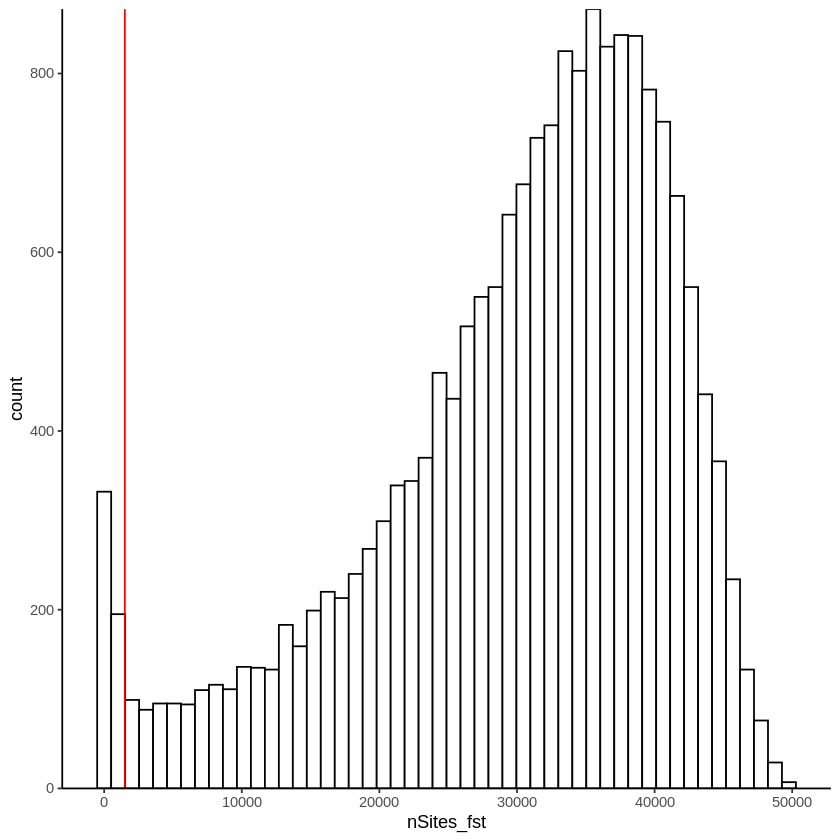

In [8]:
# What does the distribution of the number of sites per window look like?
# Keep windows with at least 200 sites. 
allStats_windowed_df %>% 
    ggplot(., aes(x = nSites_fst)) +
    geom_histogram(bins = 50, color = 'black', fill = 'white') +
    geom_vline(xintercept = 1500, color = 'red') +
    scale_y_continuous(expand = c(0, 0)) +
    theme_classic()

In [9]:
# Identify outliers across genome
nSites_thresh <- 1500
allStats_windowed_filt <- allStats_windowed_df %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(allStats_windowed_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

allStats_windowed_filt <- allStats_windowed_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0)) %>%
    dplyr::select(chrom_pos, Chr, start, end, WinCenter, fst, delta_tp_ur, delta_td_ur, contains('_outlier'))

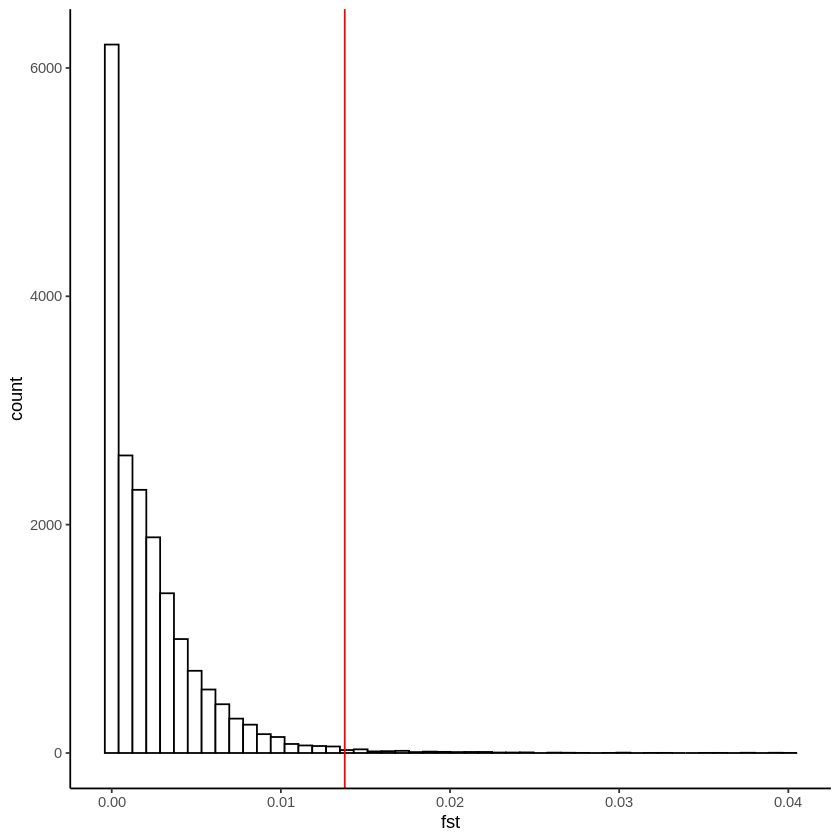

In [10]:
allStats_windowed_filt %>% 
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 50, color = 'black', fill = 'white') +
#     scale_y_continuous(expand = c(0, 0)) +
    geom_vline(xintercept = fst_quant_filt[1], color = 'red') +
    theme_classic()

In [11]:
allStats_windowed_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the
`.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,17696
0,0,1,205
0,1,0,220
0,1,1,111
1,0,0,118
1,0,1,28
1,1,0,13
1,1,1,26


In [12]:
# Add habitat under selection based on difference in pi and Tajima's D
allStats_windowed_filt <- allStats_windowed_filt %>% 
    mutate(direction = case_when(delta_tp_ur < 0 & delta_td_ur < 0 ~ 'Urban sel',
                                 delta_tp_ur > 0 & delta_td_ur > 0 ~ 'Rural sel',
                                 TRUE ~ 'Weird'))

In [13]:
allStats_windowed_filt %>% filter(all_outlier == 1) %>% group_by(direction) %>% summarise(n = n())

direction,n
<chr>,<int>
Rural sel,13
Urban sel,13


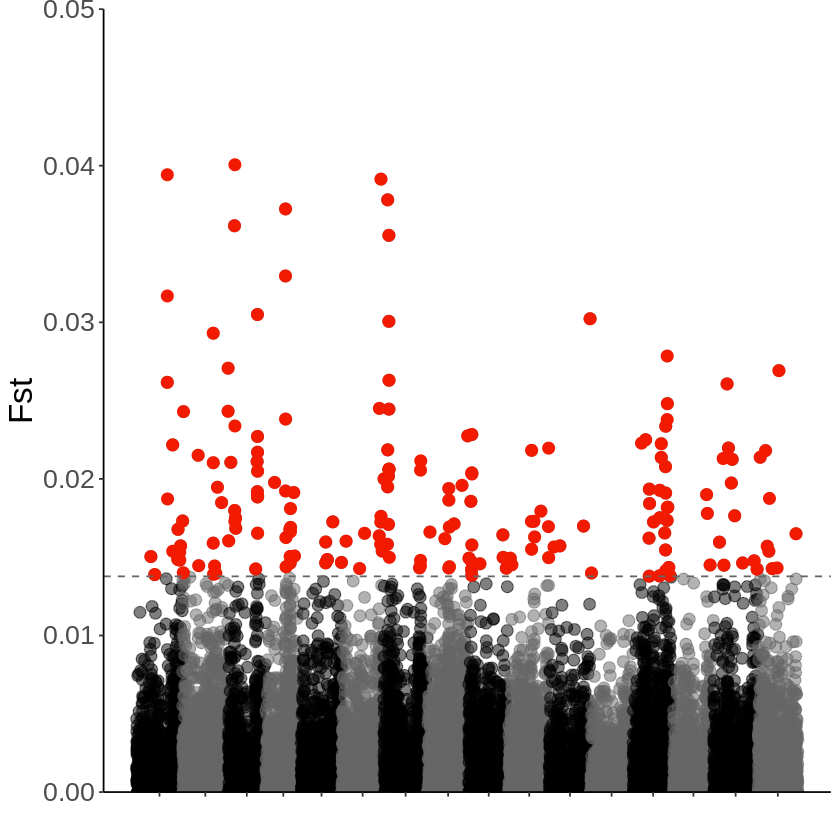

In [57]:
data_cum <- allStats_windowed_filt %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

allStats_windowed_filt_mod <- allStats_windowed_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- allStats_windowed_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

urban_outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1 & direction == 'Urban sel')
rural_outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1 & direction == 'Rural sel')
fst_outliers <- allStats_windowed_filt_mod %>% filter(fst_outlier == 1)

manhat_plot <- allStats_windowed_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'Chr01_Occ' ~ 'One',
                                 Chr == 'Chr01_Pall' ~ 'Two',
                                 Chr == 'Chr02_Occ' ~ 'One',
                                 Chr == 'Chr02_Pall' ~ 'Two',
                                 Chr == 'Chr03_Occ' ~ 'One',
                                 Chr == 'Chr03_Pall' ~ 'Two',
                                 Chr == 'Chr04_Occ' ~ 'One',
                                 Chr == 'Chr04_Pall' ~ 'Two',
                                 Chr == 'Chr05_Occ' ~ 'One',
                                 Chr == 'Chr05_Pall' ~ 'Two',
                                 Chr == 'Chr06_Occ' ~ 'One',
                                 Chr == 'Chr06_Pall' ~ 'Two',
                                 Chr == 'Chr07_Occ' ~ 'One',
                                 Chr == 'Chr07_Pall' ~ 'Two',
                                 Chr == 'Chr08_Occ' ~ 'One',
                                 Chr == 'Chr08_Pall' ~ 'Two')) %>%
    filter(all_outlier != 1) %>% 
    ggplot(aes(x = WinCenter_cum, y = fst)) +
        geom_point(shape = 21, alpha = 0.5, size = 3, aes(fill = chrom_cat, color = chrom_cat)) +
#         geom_point(data = urban_outliers, shape = 21, alpha = 1, size = 6, color = '#F21A00', fill = '#F21A00') +
#         geom_point(data = rural_outliers, shape = 21, alpha = 1, size = 6, color = '#F21A00', fill = '#F21A00') +
        geom_point(data = fst_outliers, shape = 21, alpha = 1, size = 3, color = '#F21A00', fill = '#F21A00') +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 0.05)) +
#         scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
#         scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        scale_fill_manual(values = c("black", "grey40")) + 
        scale_color_manual(values = c("black", "grey40")) + 
        ylab('Fst') + xlab('') +
        theme_classic() +
        theme(
#             aspect.ratio = 0.4,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text = element_text(size=16),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
#             axis.title.x = element_blank()
          )
manhat_plot

In [58]:
figures_path <- "/scratch/projects/trifolium/gwsd/figures/"
dir.create(figures_path, showWarnings = FALSE)
ggsave(filename = paste0(figures_path, 'all_outliers_fst_only.pdf'), plot = manhat_plot, device = 'pdf', 
       width = 20, height = 6, units = 'in', dpi = 600, )

In [16]:
add_fst_ranks <- function(df){
        
    df_out <- df %>% 
        arrange(desc(fst)) %>% 
        mutate(fst_rank = 1:n()) %>% 
        dplyr::select(-chrom_pos) %>% 
        arrange(Chr, WinCenter)
    return(df_out)
}

allSFSstats_windowed_filt_urbanSel_withRanks <- add_fst_ranks(urban_outliers)
allSFSstats_windowed_filt_ruralSel_withRanks <- add_fst_ranks(rural_outliers)
allSFSstats_windowed_filt_fstOutlierOnly_withRanks <- add_fst_ranks(fst_outliers)

In [17]:
allSFSstats_windowed_filt_fstOutlierOnly_withRanks

Chr,start,end,WinCenter,fst,delta_tp_ur,delta_td_ur,fst_outlier,tp_outlier,td_outlier,all_outlier,direction,WinCenter_add,WinCenter_cum,fst_rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>
Chr01_Occ,20900000,20950000,20925000,0.015039,-6.485170e-03,-0.164161,1,1,0,0,Urban sel,0,20925000,140
Chr01_Occ,26500000,26550000,26525000,0.013890,2.447702e-04,0.124228,1,0,0,0,Rural sel,0,26525000,181
Chr01_Occ,44850000,44900000,44875000,0.026166,-1.713384e-04,-0.033049,1,0,0,0,Urban sel,0,44875000,18
Chr01_Occ,44900000,44950000,44925000,0.039423,-3.682036e-03,-0.430282,1,1,1,1,Urban sel,0,44925000,2
Chr01_Occ,44950000,45000000,44975000,0.031681,-3.918067e-03,-0.569677,1,1,1,1,Urban sel,0,44975000,9
Chr01_Occ,45250000,45300000,45275000,0.018719,-3.692643e-03,-0.422226,1,1,1,1,Urban sel,0,45275000,76
Chr01_Occ,52750000,52800000,52775000,0.022171,-1.816661e-03,-0.041082,1,0,0,0,Urban sel,0,52775000,35
Chr01_Occ,52800000,52850000,52825000,0.015380,-2.921886e-03,-0.419942,1,1,1,1,Urban sel,0,52825000,135
Chr01_Occ,60200000,60250000,60225000,0.014861,1.458802e-04,0.113951,1,0,0,0,Rural sel,0,60225000,146


In [18]:
merge_fst_outlierWins <- function(df){
    df_merged <- bt.merge(i = df)
    names(df_merged) <- c('Chr', 'start', 'end')
    df_merged <- df_merged %>% 
        mutate(winSize = end - start)

    print(sprintf('There were %s Fst outlier windows prior to merging. There are %s outlier regions after merging consecutive outlier windows',
                  nrow(df), nrow(df_merged)))
    return(df_merged)
}
allSFSstats_windowed_filt_urbanSel_merged <- merge_fst_outlierWins(allSFSstats_windowed_filt_urbanSel_withRanks)
allSFSstats_windowed_filt_ruralSel_merged <- merge_fst_outlierWins(allSFSstats_windowed_filt_ruralSel_withRanks)
allSFSstats_windowed_filt_fstOutlierOnly_merged <- merge_fst_outlierWins(allSFSstats_windowed_filt_fstOutlierOnly_withRanks)

[1] "There were 13 Fst outlier windows prior to merging. There are 11 outlier regions after merging consecutive outlier windows"
[1] "There were 13 Fst outlier windows prior to merging. There are 9 outlier regions after merging consecutive outlier windows"
[1] "There were 185 Fst outlier windows prior to merging. There are 142 outlier regions after merging consecutive outlier windows"


In [19]:
write_csv(allSFSstats_windowed_filt_fstOutlierOnly_merged, paste0(figures_path, 'allSFSstats_windowed_filt_fstOutlierOnly_merged.csv'))

## XP-nSL (manual windows)

- XP-nSL is a haplotype-based scan for selective sweeps
- I calculated windowed stats using normalized XP-nSL

In [20]:
xpnsl_path <- paste0(results_prefix, 'sweeps/xpnsl/')
pattern <- '.*_Urban_Rural.xpnsl.out.norm$'
xpnsl_raw_df <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'raw') %>% 
    rename('normxpnsl' = 'normxpehh') %>% 
    dplyr::select(-id)

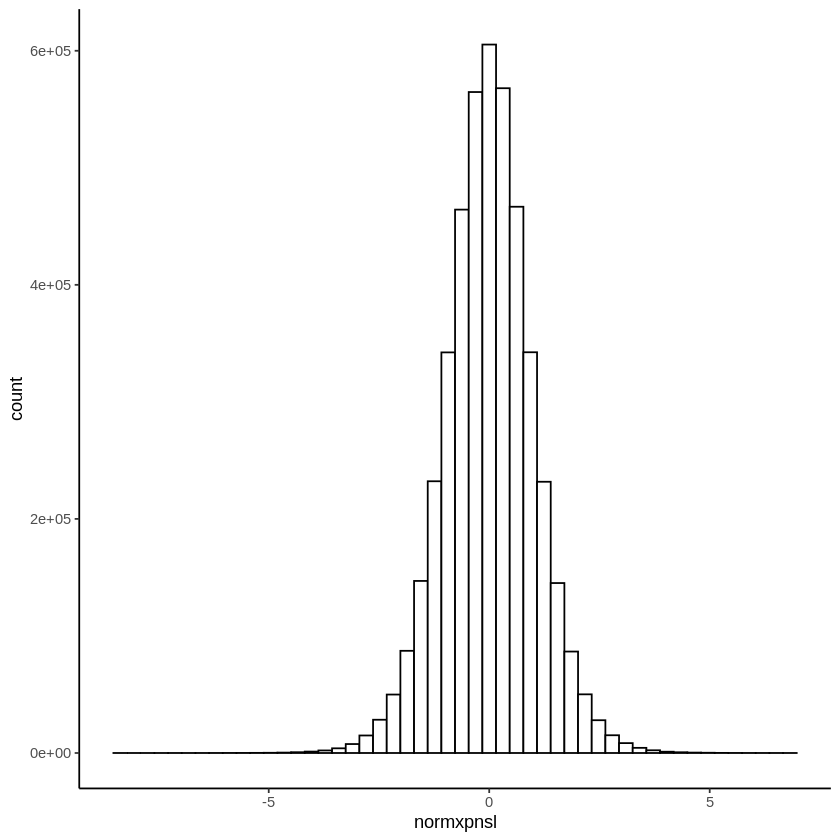

In [21]:
ggplot(xpnsl_raw_df, aes(x = normxpnsl)) +
    geom_histogram(bins = 50, color = 'black', fill = 'white') +
    theme_classic()

In [22]:
window_size = 50000
step = 50000
thresh = 2
xpnsl_windows <- xpnsl_raw_df %>% 
    group_split(Chr) %>% 
    purrr::map_dfr(., calculate_windowed_stats, window_size = window_size, step = step, thresh = thresh)

In [23]:
# Identify outliers across genome
nSites_thresh <- 10
xpnsl_windows_filt <- xpnsl_windows %>%
    mutate_at(vars(-("Chr")),as.numeric) %>% 
    filter(n >= nSites_thresh)

xpnsl_score_quant_filt <- quantile(xpnsl_windows_filt %>% pull(mean), probs = c(0.01, 0.99))
xpnsl_gtprop_quant_filt <- quantile(xpnsl_windows_filt %>% pull(gt_frac), probs = 0.99)
xpnsl_ltprop_quant_filt <- quantile(xpnsl_windows_filt %>% pull(lt_frac), probs = 0.99)

xpnsl_windows_filt <- xpnsl_windows_filt %>%
    mutate(xpnsl_score_outlier = ifelse(mean <= xpnsl_score_quant_filt[1] | mean >= xpnsl_score_quant_filt[2], 1, 0),
           xpnsl_gtprop_outlier = ifelse(gt_frac >= xpnsl_gtprop_quant_filt, 1, 0),
           xpnsl_ltprop_outlier = ifelse(lt_frac >= xpnsl_ltprop_quant_filt, 1, 0),
           direction = case_when(xpnsl_score_outlier == 1 & mean > 0 & xpnsl_gtprop_outlier == 1 ~ 'Urban sel',
                                 xpnsl_score_outlier == 1 & mean < 0 & xpnsl_ltprop_outlier == 1 ~ 'Rural sel',
                                 TRUE ~ 'Not dual outlier')) %>% 
    mutate(prop_outlier = case_when(direction == 'Urban sel' ~ gt_frac,
                                        direction == 'Rural sel' ~ lt_frac,
                                        TRUE ~ NA))

In [24]:
highest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl)))
lowest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == min(xpnsl_raw_df %>% pull(normxpnsl)))
highest_xpnsl_score
lowest_xpnsl_score

pos,gpos,p1,sL1,p2,sL2,xpnsl,normxpnsl,crit,Chr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4826115,22774,0.0121951,59.0834,0.109756,22.8997,0.411635,6.72868,1,Chr05_Occ


pos,gpos,p1,sL1,p2,sL2,xpnsl,normxpnsl,crit,Chr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
16624678,77581,0.52439,10.554,0.268293,34.6227,-0.515942,-8.45624,-1,Chr08_Pall


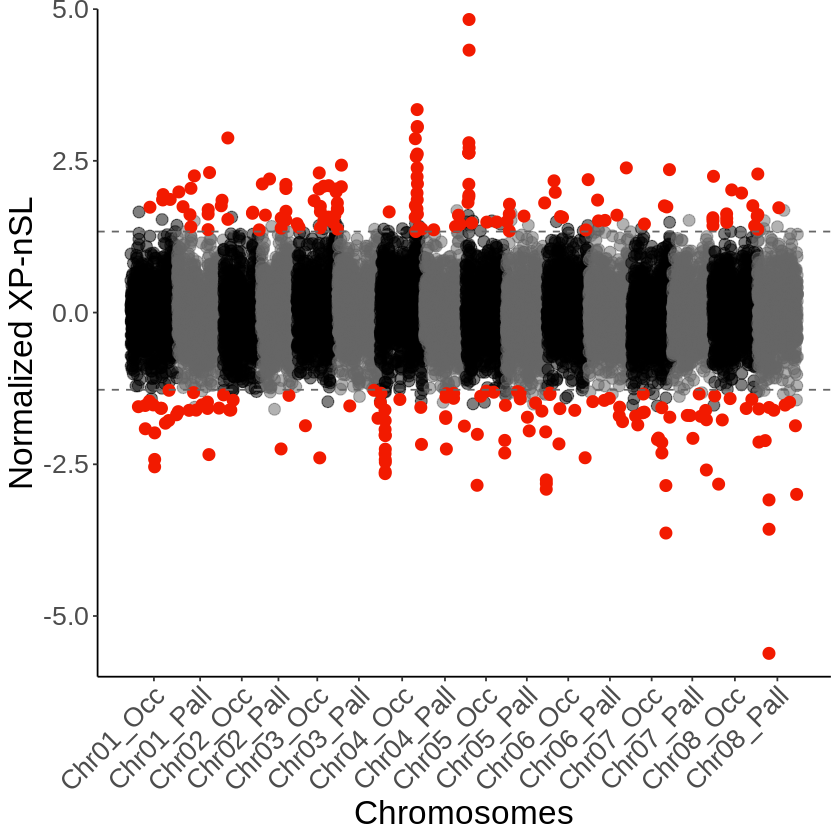

In [55]:
data_cum <- xpnsl_windows_filt %>% 
    group_by(Chr) %>% 
    summarise(max_winCenter = max(winCenter)) %>% 
    mutate(winCenter_add = lag(cumsum(max_winCenter), default = 0)) %>% 
    dplyr::select(Chr, winCenter_add)

xpnsl_windows_filt_mod <- xpnsl_windows_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(winCenter_cum = winCenter + winCenter_add) 

axis_set <- xpnsl_windows_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(winCenter_cum))

all_xpnsl_outliers <- xpnsl_windows_filt_mod %>% filter(direction != 'Not dual outlier')
urban_xpnsl_outliers <- xpnsl_windows_filt_mod %>% filter(direction == 'Urban sel')
rural_xpnsl_outliers <- xpnsl_windows_filt_mod %>% filter(direction == 'Rural sel')

xpnsl_windows_filt_mod <- xpnsl_windows_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'Chr01_Occ' ~ 'One',
                                 Chr == 'Chr01_Pall' ~ 'Two',
                                 Chr == 'Chr02_Occ' ~ 'One',
                                 Chr == 'Chr02_Pall' ~ 'Two',
                                 Chr == 'Chr03_Occ' ~ 'One',
                                 Chr == 'Chr03_Pall' ~ 'Two',
                                 Chr == 'Chr04_Occ' ~ 'One',
                                 Chr == 'Chr04_Pall' ~ 'Two',
                                 Chr == 'Chr05_Occ' ~ 'One',
                                 Chr == 'Chr05_Pall' ~ 'Two',
                                 Chr == 'Chr06_Occ' ~ 'One',
                                 Chr == 'Chr06_Pall' ~ 'Two',
                                 Chr == 'Chr07_Occ' ~ 'One',
                                 Chr == 'Chr07_Pall' ~ 'Two',
                                 Chr == 'Chr08_Occ' ~ 'One',
                                 Chr == 'Chr08_Pall' ~ 'Two')) %>%
    filter(direction == 'Not dual outlier')

xpnsl_manhat <- ggplot() +
        geom_point(data = xpnsl_windows_filt_mod, shape = 21, alpha = 0.5, size = 3, 
                   aes(x = winCenter_cum, y = mean, fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = all_xpnsl_outliers, shape = 21, alpha = 1, size = 3, color = '#F21A00', fill = '#F21A00',
                   aes(x = winCenter_cum, y = mean)) +
#         geom_point(data = rural_outliers, shape = 21, alpha = 1, size = 1, color = 'green', fill = 'green') +
        geom_hline(yintercept = xpnsl_score_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(-6, 5)) +
        scale_fill_manual(values = c("black", "grey40")) + 
        scale_color_manual(values = c("black", "grey40")) + 
        ylab('Normalized XP-nSL') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text = element_text(size=16),
            axis.title = element_text(size=20),
            axis.text.x = element_text(angle = 45, hjust = 1)
          )
xpnsl_manhat

In [56]:
ggsave(filename = paste0(figures_path, 'all_outliers_xpnsl_only.pdf'), plot = xpnsl_manhat, device = 'pdf', 
       width = 20, height = 6, units = 'in', dpi = 600, )

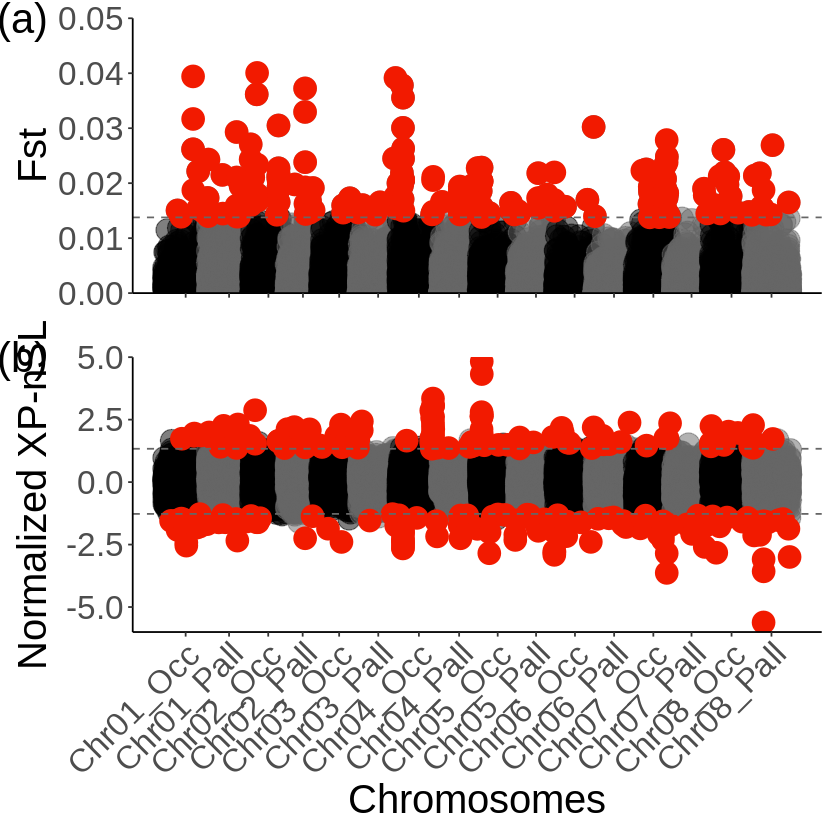

In [27]:
# figure3 <- manhat_plot / xpnsl_manhat + 
#     plot_annotation(tag_levels = 'a', tag_prefix = '(', tag_suffix = ')') &
#     theme(plot.tag.position = c(0.005, 1.0),
#         plot.tag = element_text(size = 25),
#         axis.text = element_text(size=20),
#         axis.title = element_text(size=24))
# figure3

In [28]:
# ggsave(filename = paste0(figures_path, 'figure3.pdf'), plot = figure3, device = 'pdf', 
#        width = 25, height = 13, units = 'in', dpi = 600)
# ggsave(filename = paste0(figures_path, 'figure3.png'), plot = figure3, device = 'png', 
#        width = 25, height = 13, units = 'in', dpi = 600)
# ggsave(filename = paste0(figures_path, 'figure3.jpeg'), plot = figure3, device = 'jpeg', 
#     width = 25, height = 13, units = 'in', dpi = 600)

In [29]:
add_xpnsl_ranks <- function(df){
        
    df_out <- df %>% 
        arrange(desc(prop_outlier)) %>% 
        mutate(xpnsl_rank = 1:n())
    return(df_out)
}

xpnsl_windowed_filt_urbanSel_withRanks <- add_xpnsl_ranks(urban_xpnsl_outliers)
xpnsl_windowed_filt_ruralSel_withRanks <- add_xpnsl_ranks(rural_xpnsl_outliers)
xpnsl_windowed_filt_allSelection_withRanks <- add_xpnsl_ranks(all_xpnsl_outliers)

In [30]:
xpnsl_windowed_filt_urbanSel_withRanks

Chr,winID,start,end,winCenter,mean,max,min,n,num_gt_thresh,⋯,gt_frac,lt_frac,xpnsl_score_outlier,xpnsl_gtprop_outlier,xpnsl_ltprop_outlier,direction,prop_outlier,winCenter_add,winCenter_cum,xpnsl_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Chr04_Occ,1080,53955352,54005352,53980352,3.065946,3.94304,2.120080,22,22,⋯,1.0000000,0,1,1,0,Urban sel,1.0000000,361667553,415647905,1
Chr05_Occ,96,4760042,4810042,4785042,4.829026,5.30822,4.401840,41,41,⋯,1.0000000,0,1,1,0,Urban sel,1.0000000,485875436,490660478,2
Chr05_Occ,97,4810042,4860042,4835042,4.324254,6.72868,1.866390,212,205,⋯,0.9669811,0,1,1,0,Urban sel,0.9669811,485875436,490710478,3
Chr04_Occ,1021,51005352,51055352,51030352,2.864893,4.54608,1.554470,111,106,⋯,0.9549550,0,1,1,0,Urban sel,0.9549550,361667553,412697905,4
Chr04_Occ,1074,53655352,53705352,53680352,3.344564,5.81433,1.253440,289,265,⋯,0.9169550,0,1,1,0,Urban sel,0.9169550,361667553,415347905,5
Chr05_Occ,91,4510042,4560042,4535042,2.798861,4.21664,1.151340,332,293,⋯,0.8825301,0,1,1,0,Urban sel,0.8825301,485875436,490410478,6
Chr04_Occ,1048,52355352,52405352,52380352,2.571959,3.73806,1.186230,44,36,⋯,0.8181818,0,1,1,0,Urban sel,0.8181818,361667553,414047905,7
Chr05_Occ,98,4860042,4910042,4885042,2.713871,4.07251,-1.236140,124,99,⋯,0.7983871,0,1,1,0,Urban sel,0.7983871,485875436,490760478,8
Chr03_Pall,107,5308039,5358039,5333039,2.429141,3.16578,0.672751,34,27,⋯,0.7941176,0,1,1,0,Urban sel,0.7941176,300184514,305517553,9


In [31]:
merge_xpnsl_windows <- function(df, habitat){
    
    df_sorted <- df %>% 
        dplyr::select(Chr, start, end, everything()) %>% 
        arrange(Chr, start)

    if(habitat == 'urban'){
        cols <- c('6,7,12,17,21')
        operation <- c('mean,max,mean,distinct,min')
        colnames <- c('Chr', 'start', 'end', 'mean_xpnsl', 'max_xpnsl', 'mean_gt_frac', 'direction', 'xpnsl_rank')
    }else if(habitat == 'rural'){
        cols <- c('6,8,13,17,21')
        operation <- c('mean,min,mean,distinct,min')
        colnames <- c('Chr', 'start', 'end', 'mean_xpnsl', 'min_xpnsl', 'mean_lt_frac', 'direction', 'xpnsl_rank')
    }else{
        cols <- c('6,7,8,18,17,21')
        operation <- c('mean,max,min,mean,distinct,min')
        colnames <- c('Chr', 'start', 'end', 'mean_xpnsl', 'max_xpnsl', 'min_xpnsl', 'mean_prop_outlier', 'direction', 'xpnsl_rank')
    }
    
    df_merged  <- bt.merge(i = df_sorted, c = cols, o = operation)
    names(df_merged) <- colnames
    df_merged <- df_merged %>% 
        mutate(winSize = end - start)

    print(sprintf('There were %s XP-nSL outlier windows prior to merging. There are %s outlier regions after merging consecutive outlier windows',
                  nrow(df_sorted), nrow(df_merged)))
    return(df_merged)
}

# Merge adjacent windows exhibiting signatures of urban selection
xpnsl_urbanSel_windows_merged <- merge_xpnsl_windows(xpnsl_windowed_filt_urbanSel_withRanks, habitat = 'urban') 
xpnsl_ruralSel_windows_merged <- merge_xpnsl_windows(xpnsl_windowed_filt_ruralSel_withRanks, habitat = 'rural') 
xpnsl_allSelection_merged <- merge_xpnsl_windows(xpnsl_windowed_filt_allSelection_withRanks, habitat = 'all')

[1] "There were 130 XP-nSL outlier windows prior to merging. There are 102 outlier regions after merging consecutive outlier windows"
[1] "There were 128 XP-nSL outlier windows prior to merging. There are 109 outlier regions after merging consecutive outlier windows"
[1] "There were 258 XP-nSL outlier windows prior to merging. There are 211 outlier regions after merging consecutive outlier windows"


In [32]:
write_csv(xpnsl_allSelection_merged, paste0(figures_path, 'xpnsl_allSelection_merged.csv'))

## Overlap

In [33]:
get_positions <- function(df){
    df_out <- df %>% 
        dplyr::select(Chr, start, end)
    return(df_out)
}

xpnsl_urbanSel_windows_pos <- get_positions(xpnsl_urbanSel_windows_merged) 
fst_urbanSel_windows_pos <- get_positions(allSFSstats_windowed_filt_urbanSel_withRanks)
print(sprintf("There are %s urban outlier XP-nSL regions and %s urban outlier Fst/pi/Td windows", 
              nrow(xpnsl_urbanSel_windows_pos), nrow(fst_urbanSel_windows_pos)))

xpnsl_ruralSel_windows_pos <- get_positions(xpnsl_ruralSel_windows_merged) 
fst_ruralSel_windows_pos <- get_positions(allSFSstats_windowed_filt_ruralSel_withRanks)
print(sprintf("There are %s rural outlier XP-nSL regions and %s rural outlier Fst/pi/Td windows", 
              nrow(xpnsl_ruralSel_windows_pos), nrow(fst_ruralSel_windows_pos)))

xpnsl_allSelection_windows_pos <- get_positions(xpnsl_allSelection_merged) 
fstOutlierOnly_windows_pos <- get_positions(allSFSstats_windowed_filt_fstOutlierOnly_merged)
print(sprintf("There are %s rural outlier XP-nSL regions and %s rural outlier Fst/pi/Td windows", 
              nrow(xpnsl_allSelection_windows_pos), nrow(fstOutlierOnly_windows_pos)))

[1] "There are 102 urban outlier XP-nSL regions and 13 urban outlier Fst/pi/Td windows"
[1] "There are 109 rural outlier XP-nSL regions and 13 rural outlier Fst/pi/Td windows"
[1] "There are 211 rural outlier XP-nSL regions and 142 rural outlier Fst/pi/Td windows"


In [34]:
numFstoutliers_byXpnsl <- function(xpnsl_pos, fst_pos){
    
    # Count number of overlapping Fst outlier windows in each XP-nSL window
    df_out <- bt.intersect(xpnsl_pos, fst_pos, c = T) %>% filter(V4 > 0)
    names(df_out) <- c('Chr', 'xpnsl_win_start', 'xpnsl_win_end', 'num_fst_outliers')
    df_out  <- df_out %>% 
        mutate(size = xpnsl_win_end - xpnsl_win_start)
    
    print(sprintf("There are %s XP-nSL windows with at least one overlapping Fst outlier window. This represents %s percent of all all XP-nSL windows",
                 nrow(df_out), round((nrow(df_out) / nrow(xpnsl_pos)) * 100, 2)))
    
    return(df_out)
}

print('Urban')
xpnsl_urban_numUrbanOutliers <- numFstoutliers_byXpnsl(xpnsl_urbanSel_windows_pos, fst_urbanSel_windows_pos)
print(xpnsl_urban_numUrbanOutliers)

print('Rural')
xpnsl_rural_numRuralOutliers <- numFstoutliers_byXpnsl(xpnsl_ruralSel_windows_pos, fst_ruralSel_windows_pos)
print(xpnsl_rural_numRuralOutliers)

print('All')
allxpnsl_numFstOutliers <- numFstoutliers_byXpnsl(xpnsl_allSelection_windows_pos, fstOutlierOnly_windows_pos)
print(allxpnsl_numFstOutliers)

[1] "Urban"
[1] "There are 4 XP-nSL windows with at least one overlapping Fst outlier window. This represents 3.92 percent of all all XP-nSL windows"
        Chr xpnsl_win_start xpnsl_win_end num_fst_outliers   size
1 Chr04_Occ        53605352      53905352                3 300000
2 Chr04_Occ        54055352      54155352                1 100000
3 Chr05_Occ         4360042       4410042                1  50000
4 Chr05_Occ         4760042       4910042                1 150000
[1] "Rural"
[1] "There are 4 XP-nSL windows with at least one overlapping Fst outlier window. This represents 3.67 percent of all all XP-nSL windows"
         Chr xpnsl_win_start xpnsl_win_end num_fst_outliers   size
1 Chr05_Pall        58252905      58352905                1 100000
2  Chr07_Occ        49767332      49867332                3 100000
3  Chr08_Occ        14020573      14070573                1  50000
4 Chr08_Pall        16572347      16722347                1 150000
[1] "All"
[1] "There are 37 XP-nSL 

In [35]:
# Get ranks of XP-nSL windows with overlapping Fst outlier windows

# Urban
bt.intersect(xpnsl_urbanSel_windows_merged %>% dplyr::select(Chr, start, end, xpnsl_rank), 
             xpnsl_urban_numUrbanOutliers)  %>% 
    arrange(V4)

# Rural
bt.intersect(xpnsl_ruralSel_windows_merged %>% dplyr::select(Chr, start, end, xpnsl_rank), 
             xpnsl_rural_numRuralOutliers) %>% 
    arrange(V4)

# All
bt.intersect(xpnsl_allSelection_merged %>% dplyr::select(Chr, start, end, xpnsl_rank), 
             allxpnsl_numFstOutliers) %>% 
    arrange(V4)

V1,V2,V3,V4
<chr>,<int>,<int>,<int>
Chr05_Occ,4760042,4910042,2
Chr04_Occ,53605352,53905352,5
Chr04_Occ,54055352,54155352,32
Chr05_Occ,4360042,4410042,101


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
Chr08_Pall,16572347,16722347,1
Chr07_Occ,49767332,49867332,3
Chr05_Pall,58252905,58352905,11
Chr08_Occ,14020573,14070573,40


V1,V2,V3,V4
<chr>,<int>,<int>,<int>
Chr05_Occ,4760042,4910042,2
Chr08_Pall,16572347,16722347,3
Chr07_Occ,49767332,49867332,7
Chr04_Occ,53605352,53905352,8
Chr05_Occ,4460042,4710042,9
Chr04_Occ,7305352,7605352,10
Chr05_Occ,4260042,4310042,21
Chr05_Pall,58252905,58352905,23
Chr05_Occ,16410042,16460042,28


In [36]:
gff <- ape::read.gff('/research/projects/trifolium/dovetail/test_prot_blast/UTM_Trep_v1.0.gff3', GFF3 = TRUE) %>% 
    dplyr::select(seqid, start, end, everything())

In [37]:
outlier_annotations <- function(xpnsl_outliers, gff){

    outlier_genes <- bt.intersect(gff, xpnsl_outliers, wb = T) %>% 
        filter(V5 == 'gene')  %>% 
        dplyr::select(V1, V2, V3, V9, V11, V12, V13)

    names(outlier_genes) <- c('Chr', 'feat_start', 'feat_end', 'annot', 'xpnsl_win_start', 'xpnsl_win_end', 'xpnsl_rank')
    outlier_genes <- outlier_genes %>% 
        mutate(gene = str_extract(annot, pattern = '(?<=gene=)\\w+(?=;)')) %>% 
        dplyr::select(Chr, feat_start, feat_end, gene) %>% 
        distinct()
    
    outlier_mrna <- bt.intersect(gff, xpnsl_outliers, wb = T) %>% 
        filter(V5 == 'mRNA') %>% 
        dplyr::select(V1, V2, V3, V9, V11, V12, V13)
    names(outlier_mrna) <- c('Chr', 'feat_start', 'feat_end', 'annot', 'xpnsl_win_start', 'xpnsl_win_end', 'xpnsl_rank')
    outlier_mrna <- outlier_mrna %>% 
        mutate(func = str_extract(annot, pattern = '(?<=product=)[^;]*'),
               go = str_extract_all(annot, pattern = '(?<=GO:)\\d+(?=(,|;))'),
               ip = str_extract_all(annot, pattern = '(?<=InterPro:)IPR\\d+(?=(,|;))'),
               en = str_extract_all(annot, pattern = '(?<=EggNog:)[^(;|,)]*'),
               cazy = str_extract_all(annot, pattern = '(?<=CAZy:)[^(;|,)]*'),
               pfam = str_extract_all(annot, pattern = '(?<=PFAM:)PF\\d+(?=(,|;))')) %>%
        dplyr::select(-annot) %>%
        arrange(Chr, xpnsl_win_start) %>% 
        distinct()
       
    out <- left_join(outlier_mrna, outlier_genes, by = c('Chr', 'feat_start', 'feat_end'))
    return(out)
}
options(repr.matrix.max.rows=50, repr.matrix.max.cols=200)

In [38]:
# xpnsl_urbanSel_windows_forJoin <- xpnsl_urbanSel_windows_merged %>% 
#     dplyr::select(Chr, start, end, mean_xpnsl, max_xpnsl, mean_gt_frac) %>% 
#     rename("xpnsl_win_start" = 'start',
#            "xpnsl_win_end" = 'end') %>% 
#     filter(xpnsl_win_start %in% outlier_genes_xpnsl_fst$xpnsl_win_start)
# xpnsl_fst_overlap_transcripts <- outlier_genes_xpnsl_fst %>% 
#     distinct() %>% 
#     group_by(Chr, xpnsl_win_start, xpnsl_win_end) %>% 
#     summarise(num_transcripts = n(),
#               accessions = toString(accession)) %>% 
#     left_join(xpnsl_regions_numFstOutliers, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end')) %>% 
#     left_join(xpnsl_urbanSel_windows_forJoin, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end'))
# xpnsl_fst_overlap_transcripts
# write_csv(x = xpnsl_fst_overlap_transcripts, path = paste0(figures_path, 'xpnsl_fst_overlap_transcripts.csv'))

In [39]:
# Annotations for Top XP-nSL hits
xpnsl_urbanSel_top10 <- xpnsl_urbanSel_windows_merged %>% 
    filter(xpnsl_rank <= 10) %>% 
    dplyr::select(Chr, start, end, xpnsl_rank) %>% 
    arrange(Chr, start)
xpnsl_urbanSel_top10_annot <- outlier_annotations(xpnsl_urbanSel_top10, gff) %>% 
    dplyr::select(Chr, feat_start, feat_end, xpnsl_win_start, xpnsl_win_end, xpnsl_rank, func, gene) %>% 
    arrange(xpnsl_rank)

In [70]:
xpnsl_urbanSel_top10

Chr,start,end,xpnsl_rank
<chr>,<int>,<int>,<int>
Chr03_Pall,5308039,5358039,9
Chr04_Occ,51005352,51105352,4
Chr04_Occ,52355352,52405352,7
Chr04_Occ,53605352,53905352,5
Chr04_Occ,53955352,54005352,1
Chr05_Occ,4460042,4710042,6
Chr05_Occ,4760042,4910042,2


In [41]:
# xpnsl_urbanSel_windows_forJoin <- xpnsl_urbanSel_windows %>% 
#     dplyr::select(Chr, start, end, mean, max, gt_frac) %>% 
#     rename("xpnsl_win_start" = 'start',
#            "xpnsl_win_end" = 'end')
# outlier_genes_xpnsl_top10 <- outlier_genes_xpnsl_top10 %>% 
#     mutate(func = str_extract(annot, pattern = '(?<=product=)[^;]*'),
#            go = str_extract_all(annot, pattern = '(?<=GO:)\\d+(?=(,|;))'),
#            ip = str_extract_all(annot, pattern = '(?<=InterPro:)IPR\\d+(?=(,|;))'),
#            en = str_extract_all(annot, pattern = '(?<=EggNog:)[^(;|,)]*'),
#            cazy = str_extract_all(annot, pattern = '(?<=CAZy:)[^(;|,)]*'),
#            pfam = str_extract_all(annot, pattern = '(?<=PFAM:)PF\\d+(?=(,|;))')) %>%
#     dplyr::select(-annot) %>% 
#     arrange(sel_rank) %>% 
#     distinct()
# outlier_genes_xpnsl_top10

# outlier_genes_xpnsl_top10 %>% 
#     group_by(Chr, xpnsl_win_start, xpnsl_win_end) %>% 
#     summarise(num_transcripts = n()) %>% 
#     left_join(outlier_genes_xpnsl_top10 %>% dplyr::select(Chr, xpnsl_win_start, xpnsl_win_end, sel_rank)) %>% 
#     distinct() %>% 
#     left_join(xpnsl_urbanSel_windows_forJoin, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end')) 
# %>% 
#     write_csv(paste0(figures_path, 'xpnsl_top10_transcript.csv'))

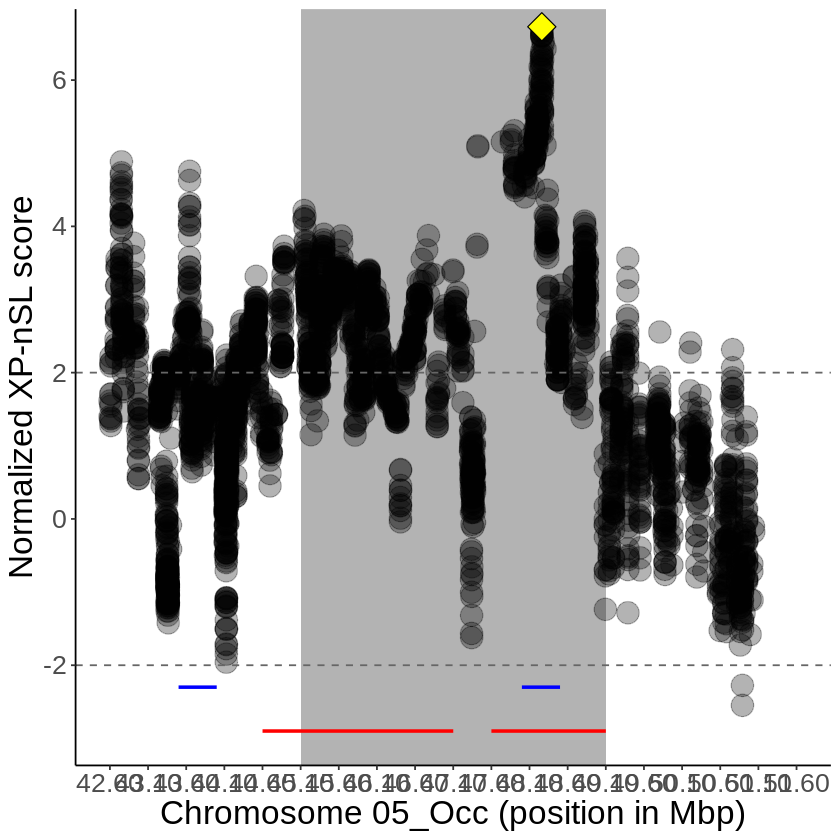

In [68]:
min_pos <- 4510042
max_pos <- 4910042
buffer <- 250000

chr5Occ_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'Chr05_Occ' & pos >= min_pos - buffer & pos <= max_pos + buffer) %>% 
    filter(!(gpos %in% highest_xpnsl_score$gpos))

formatter1e6 <- function(x){ 
    x <- x / 1e5
    return(sprintf(x, fmt = '%#.2f'))
}

xmin = 4510000 - buffer
xmax = 4910000 + buffer

fst_wins <- bt.intersect(fst_urbanSel_windows_pos, xpnsl_urbanSel_windows_pos, wa = T)  %>% 
    rename('Chr' = 'V1', 'start' = 'V2', 'end' = 'V3') %>% 
    filter(Chr == 'Chr05_Occ')

top_xpnsl <- xpnsl_urbanSel_top10 %>% 
    filter(Chr == 'Chr05_Occ')

chr5Occ_outlier_region_manhat <- ggplot(chr5Occ_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 6, fill = 'black', alpha = 0.3) +
    geom_point(data = highest_xpnsl_score, shape = 23, size = 6, fill = 'yellow', alpha = 1) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 05_Occ (position in Mbp)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-2.9, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 50000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.3, yend = -2.3, color = 'blue', size = 1) +
    geom_segment(data = top_xpnsl, aes(x = start, xend = end), y = -2.9, yend = -2.9, color = 'red', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr5Occ_outlier_region_manhat
ggsave(filename = paste0(figures_path, 'chr5Occ_outlier_region_manhat.pdf'), plot = chr5Occ_outlier_region_manhat, device = 'pdf', 
       width = 12, height = 8, units = 'in', dpi = 600)

In [71]:
xpnsl_urbanSel_top10_annot %>% 
    filter(Chr == 'Chr05_Occ') 
# %>% 
#     write_csv(paste0(figures_path, 'chr05Occ_outlier_region_annot.csv'))

Chr,feat_start,feat_end,xpnsl_win_start,xpnsl_win_end,xpnsl_rank,func,gene
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
Chr05_Occ,4760042,4764218,4760042,4910042,2,ascorbate ferrireductase (transmembrane),NA
Chr05_Occ,4766867,4767662,4760042,4910042,2,hypothetical protein,NA
Chr05_Occ,4781176,4782475,4760042,4910042,2,hypothetical protein,NA
Chr05_Occ,4784361,4786444,4760042,4910042,2,hypothetical protein,NA
Chr05_Occ,4790435,4790845,4760042,4910042,2,hypothetical protein,NA
Chr05_Occ,4804797,4805588,4760042,4910042,2,transcriptional regulator,PALM1
Chr05_Occ,4816503,4820551,4760042,4910042,2,hypothetical protein,NA
Chr05_Occ,4816503,4820551,4760042,4910042,2,nuclear pore complex protein NUP98A isoform X5 [Trifolium pratense],NA
Chr05_Occ,4820601,4821066,4760042,4910042,2,nucleoporin autopeptidase [Trifolium pratense],NA


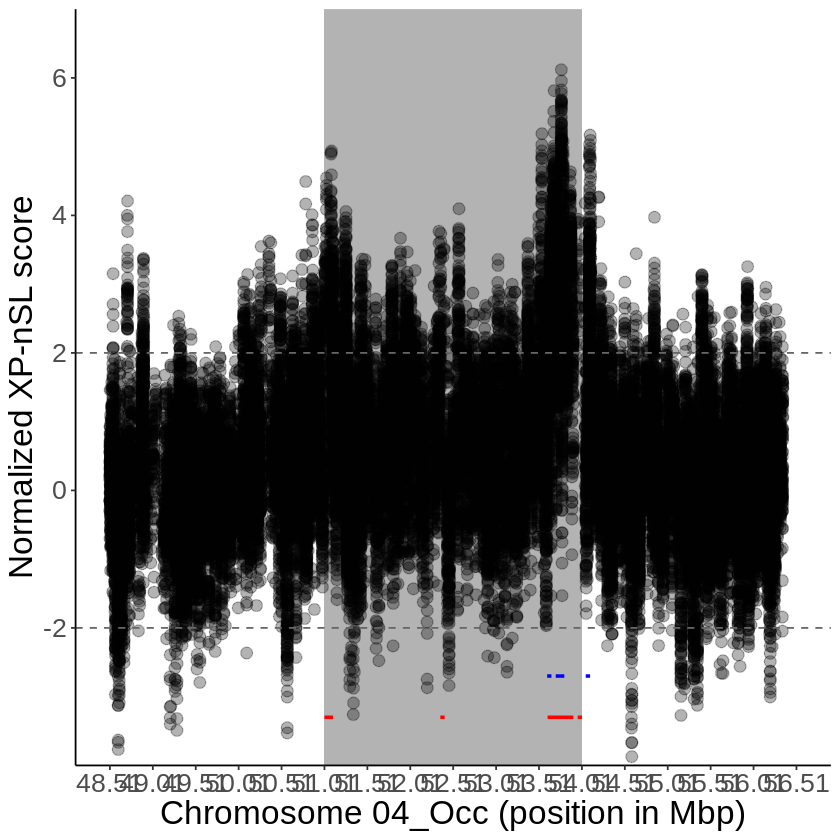

In [63]:
min_pos <- 51005352
max_pos <- 54005352
buffer <- 2500000

chr4Occ_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'Chr04_Occ' & pos >= min_pos - buffer & pos <= max_pos + buffer) %>% 
    filter(!(gpos %in% highest_xpnsl_score$gpos))

xmin = 51005000 - buffer
xmax = 54006000 + buffer

fst_wins <- bt.intersect(fst_urbanSel_windows_pos, xpnsl_urbanSel_windows_pos, wa = T)  %>% 
    rename('Chr' = 'V1', 'start' = 'V2', 'end' = 'V3') %>% 
    filter(Chr == 'Chr04_Occ')

top_xpnsl <- xpnsl_urbanSel_top10 %>% 
    filter(Chr == 'Chr04_Occ')

chr04Occ_outlier_region_manhat <- ggplot(chr4Occ_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 3, fill = 'black', alpha = 0.3) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 04_Occ (position in Mbp)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-3.5, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 500000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.7, yend = -2.7, color = 'blue', size = 1) +
    geom_segment(data = top_xpnsl, aes(x = start, xend = end), y = -3.3, yend = -3.3, color = 'red', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr04Occ_outlier_region_manhat
ggsave(filename = paste0(figures_path, 'chr04Occ_outlier_region_manhat.pdf'), plot = chr04Occ_outlier_region_manhat, device = 'pdf', 
       width = 12, height = 8, units = 'in', dpi = 600)

In [45]:
xpnsl_urbanSel_top10_annot %>% 
    filter(Chr == 'Chr04_Occ') %>% 
    arrange(feat_start) %>% 
    write_csv(paste0(figures_path, 'chr04Occ_outlier_region_annot.csv'))

In [46]:
# figure4 <- chr9_outlier_region_manhat + chr10_outlier_region_manhat + chr13_outlier_region_manhat + 
#     plot_annotation(tag_levels = 'a', tag_prefix = '(', tag_suffix = ')') &
#     theme(plot.tag.position = c(0.005, 1.0),
#         plot.tag = element_text(size = 25),
#         axis.text = element_text(size=20),
#         axis.title = element_text(size=24))
# figure4

In [47]:
# ggsave(filename = paste0(figures_path, 'figure4.pdf'), plot = figure4, device = 'pdf', 
#        width = 25, height = 8, units = 'in', dpi = 600, )
# ggsave(filename = paste0(figures_path, 'figure4.png'), plot = figure4, device = 'png', 
#        width = 25, height = 8, units = 'in', dpi = 600, )
# ggsave(filename = paste0(figures_path, 'figure4.jpeg'), plot = figure4, device = 'jpeg', 
#        width = 25, height = 8, units = 'in', dpi = 600, )

In [67]:
outlier_annotations(xpnsl_allSelection_merged, gff) %>% 
    dplyr::select(Chr, feat_start, feat_end, xpnsl_win_start, xpnsl_win_end, xpnsl_rank, func, gene) %>% 
    filter(Chr == 'Chr04_Occ' & xpnsl_win_start >= 7000000 & xpnsl_win_start <= 7700000) %>% 
    write_csv(paste0(figures_path, 'chr04Occ_outlier_region_PicMinOverlap_annot.csv'))
    

### Do more XP-nSL windows have overlapping Fst outlier windows than expected by chance?

In [48]:
xpnsl_regions_numFstOutliers_urbanAll <- bt.intersect(xpnsl_windows_filt %>% filter(mean > 0) %>% dplyr::select(Chr, start, end), fst_urbanSel_windows_pos, c = T)

In [49]:
set.seed(42)
prop_withOutliers <- c()
for(i in 1:1000){
    prop <- xpnsl_regions_numFstOutliers_urbanAll %>% 
        sample_n(100, replace = F) %>% 
        mutate(contains_outlier = ifelse(V4 > 0, 1, 0)) %>% 
        summarise(count = sum(contains_outlier),
                  prop = count / n()) %>% 
        pull(prop)
    prop_withOutliers[i] <- prop
}
prop_withOutliers

[1] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01
  [15] 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00
  [29] 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00
  [43] 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  [57] 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  [71] 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  [85] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  [99] 0.02 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [113] 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
 [127] 0.02 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.00 0.00
 [141] 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [155] 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.01
 [169] 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
 [183] 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.01
 [197] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00
 [211] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
 [225] 0.01 0.00 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.01 0.01 0.00 0.00
 [239] 0.01 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00
 [253] 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00
 [267] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.00
 [281] 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00
 [295] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02
 [309] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
 [323] 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [337] 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00
 [351] 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
 [365] 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.00 0.01 0.00 0.00 0.00 0.00
 [379] 0.00 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00
 [393] 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
 [407] 0.00 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00
 [421] 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00
 [435] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00
 [449] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.01
 [463] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [477] 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.01 0.00 0.00
 [491] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00
 [505] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [519] 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00
 [533] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [547] 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00
 [561] 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00
 [575] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00
 [589] 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00
 [603] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00
 [617] 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [631] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00
 [645] 0.00 0.02 0.00 0.00 0.00 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [659] 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 [673] 0.00 0.02 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01
 [687] 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.00
 [701] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01
 [715] 0.00 0.00 0.00 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.00 0.00

In [50]:
prop_overlapObs <- nrow(xpnsl_regions_numFstOutliers) / nrow(xpnsl_sel_windows_pos)
sum(prop_withOutliers >= prop_overlapObs) / 1000

ERROR: Error in nrow(xpnsl_regions_numFstOutliers): object 'xpnsl_regions_numFstOutliers' not found


In [ ]:
xpnsl_regions_numFstOutliers_ruralAll <- bt.intersect(xpnsl_windows_filt %>% filter(mean < 0) %>% dplyr::select(Chr, start, end), fst_ruralSel_windows_pos, c = T)

In [ ]:
set.seed(42)
prop_withOutliers <- c()
for(i in 1:1000){
    prop <- xpnsl_regions_numFstOutliers_ruralAll %>% 
        sample_n(100, replace = F) %>% 
        mutate(contains_outlier = ifelse(V4 > 0, 1, 0)) %>% 
        summarise(count = sum(contains_outlier),
                  prop = count / n()) %>% 
        pull(prop)
    prop_withOutliers[i] <- prop
}
prop_withOutliers